In [0]:
# ============================================================
# 🚄 USE CASE 5: Customer Loyalty & Engagement Insights (IRCTC)
# ============================================================
# Goal:
# To identify loyal, neutral, and disengaged IRCTC users based on 
# their feedback patterns (number of reviews, average rating, sentiment ratio).
#
# Why this matters:
# This helps IRCTC recognize consistently positive passengers, 
# retain loyal customers, and target disengaged ones for improvement.
#
# Same NLP + TF-IDF pipeline used for text features to keep project consistent.
# ============================================================

# ------------------------------------------------------------
# 🧩 Step 1: Import Libraries & Initialize Spark
# ------------------------------------------------------------
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, regexp_replace, trim, when, count, avg, udf
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
import pandas as pd
import matplotlib.pyplot as plt


In [0]:
# Start Spark Session
spark = SparkSession.builder.appName("IRCTC_Customer_Loyalty_Analysis").getOrCreate()
print("✅ Spark session started successfully!")

✅ Spark session started successfully!


In [0]:
# ------------------------------------------------------------
# 📂 Step 2: Load Dataset
# ------------------------------------------------------------
file_path = "/Volumes/workspace/default/dataset2/irctc_reviews.csv"
df = spark.read.option("header", "true").csv(file_path)
print(f"✅ Dataset Loaded Successfully | Total Rows: {df.count()}")
df.show(5, truncate=False)

✅ Dataset Loaded Successfully | Total Rows: 1000
+------------------------------------+-------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|reviewId                            |userName     |content                                                                                                                                                                                                                                                                                                                                                                |score|
+------------------------------------+-------------+-------------------------------------------------------------

In [0]:
# ------------------------------------------------------------
# 🧼 Step 3: Data Cleaning & Label Creation
# ------------------------------------------------------------
def safe_to_int(x):
    try:
        return int(x)
    except:
        return None

safe_to_int_udf = udf(safe_to_int, IntegerType())
df = df.withColumn("score_int", safe_to_int_udf(trim(col("score"))))
df = df.filter(col("score_int").isNotNull() & col("content").isNotNull())

# Clean text and assign sentiment labels
df = df.withColumn("review", lower(regexp_replace(trim(col("content")), "[^a-zA-Z\\s]", "")))

df = df.withColumn(
    "label",
    when(col("score_int") >= 4, 2)
    .when(col("score_int") == 3, 1)
    .otherwise(0)
)
print("✅ Cleaned text and assigned sentiment labels.")

✅ Cleaned text and assigned sentiment labels.


In [0]:
# ------------------------------------------------------------
# 🧠 Step 4: Reuse NLP Pipeline (TF-IDF from previous use cases)
# ------------------------------------------------------------
tokenizer = Tokenizer(inputCol="review", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
hashingTF = HashingTF(inputCol="filtered_words", outputCol="rawFeatures", numFeatures=5000)
idf = IDF(inputCol="rawFeatures", outputCol="features")

# Logistic Regression for text sentiment (to reuse trained pipeline)
lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=20)
pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf, lr])

print("✅ Reusable NLP + ML pipeline ready for loyalty analysis!")

✅ Reusable NLP + ML pipeline ready for loyalty analysis!


In [0]:
# ------------------------------------------------------------
# 📊 Step 5: Simulate User Review Behavior
# ------------------------------------------------------------
# We'll assume each review is by a unique or recurring user (userName column)
df = df.withColumn("userName", when(col("userName").isNull(), "Anonymous").otherwise(col("userName")))

# Compute engagement metrics
user_metrics = (
    df.groupBy("userName")
      .agg(
          count("*").alias("review_count"),
          avg("score_int").alias("avg_score")
      )
)

# Compute positive ratio for each user
positive_df = (
    df.filter(col("label") == 2)
      .groupBy("userName")
      .agg(count("*").alias("positive_reviews"))
)

user_metrics = (
    user_metrics.join(positive_df, on="userName", how="left")
                 .fillna(0)
                 .withColumn("positive_ratio", (col("positive_reviews") / col("review_count")) * 100)
)

print("✅ Calculated user engagement metrics successfully!")
user_metrics.show(5)

✅ Calculated user engagement metrics successfully!
+--------------------+------------+---------+----------------+--------------+
|            userName|review_count|avg_score|positive_reviews|positive_ratio|
+--------------------+------------+---------+----------------+--------------+
|       Tausif Sayyed|           1|      1.0|               0|           0.0|
|     Hitter Sagar OP|           1|      5.0|               1|         100.0|
|   Sayak Chakraborty|           1|      1.0|               0|           0.0|
|       Shagun Mundra|           1|      1.0|               0|           0.0|
|I'M GREATER THAN ...|           1|      5.0|               1|         100.0|
+--------------------+------------+---------+----------------+--------------+
only showing top 5 rows


In [0]:
# ------------------------------------------------------------
# 📈 Step 6: Prepare Data for Clustering
# ------------------------------------------------------------
assembler = VectorAssembler(
    inputCols=["review_count", "avg_score", "positive_ratio"],
    outputCol="features"
)
final_df = assembler.transform(user_metrics)
print("✅ Prepared feature vector for clustering!")

✅ Prepared feature vector for clustering!


In [0]:
# ------------------------------------------------------------
# 🤖 Step 7: Apply K-Means Clustering
# ------------------------------------------------------------
kmeans = KMeans(featuresCol="features", predictionCol="cluster", k=3, seed=42)
model = kmeans.fit(final_df)
predictions = model.transform(final_df)

# Evaluate cluster quality
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print(f"✅ Clustering completed! Silhouette Score: {silhouette:.3f}")

---------------------------------------------------------------------------
IllegalArgumentException                  Traceback (most recent call last)
File <command-5285018378278131>, line 10
      8 # Evaluate cluster quality
      9 evaluator = ClusteringEvaluator()
---> 10 silhouette = evaluator.evaluate(predictions)
     11 print(f"✅ Clustering completed! Silhouette Score: {silhouette:.3f}")

File /databricks/python/lib/python3.12/site-packages/pyspark/ml/evaluation.py:110, in Evaluator.evaluate(self, dataset, params)
    108         return self.copy(params)._evaluate(dataset)
    109     else:
--> 110         return self._evaluate(dataset)
    111 else:
    112     raise TypeError("Params must be a param map but got %s." % type(params))

File /databricks/python/lib/python3.12/site-packages/pyspark/ml/util.py:609, in try_remote_evaluate.<locals>.wrapped(self, dataset)
    601     command = pb2.Command()
    602     command.ml_command.evaluate.CopyFrom(
    603         pb2.MlComman

In [0]:
# ------------------------------------------------------------
# 📊 Step 8: Analyze Cluster Results
# ------------------------------------------------------------
from pyspark.sql import functions as F

cluster_summary = (
    predictions.groupBy("cluster")
    .agg(
        F.avg("review_count").alias("avg_reviews"),
        F.avg("avg_score").alias("avg_rating"),
        F.avg("positive_ratio").alias("avg_positive_ratio")
    )
    .orderBy("cluster")
)
print("📊 Cluster Summary:")
cluster_summary.show(truncate=False)

📊 Cluster Summary:
+-------+------------------+------------------+------------------+
|cluster|avg_reviews       |avg_rating        |avg_positive_ratio|
+-------+------------------+------------------+------------------+
|0      |1.0109756097560976|1.1780487804878048|0.0               |
|1      |1.0               |4.858895705521473 |100.0             |
|2      |2.3333333333333335|2.6666666666666665|44.444444444444436|
+-------+------------------+------------------+------------------+



In [0]:
# ------------------------------------------------------------
# 💬 Step 9: Label Clusters for Loyalty Segmentation
# ------------------------------------------------------------
predictions = predictions.withColumn(
    "loyalty_segment",
    when((col("avg_score") >= 4.0) & (col("positive_ratio") >= 60), "Loyal Customer")
    .when((col("avg_score") < 3.0) & (col("positive_ratio") < 40), "Disengaged Customer")
    .otherwise("Neutral/Occasional Customer")
)

print("✅ Added loyalty segments to user clusters!")
predictions.select("userName", "review_count", "avg_score", "positive_ratio", "loyalty_segment").show(10, truncate=False)


✅ Added loyalty segments to user clusters!
+-----------------------+------------+---------+--------------+-------------------+
|userName               |review_count|avg_score|positive_ratio|loyalty_segment    |
+-----------------------+------------+---------+--------------+-------------------+
|Tausif Sayyed          |1           |1.0      |0.0           |Disengaged Customer|
|Hitter Sagar OP        |1           |5.0      |100.0         |Loyal Customer     |
|Sayak Chakraborty      |1           |1.0      |0.0           |Disengaged Customer|
|Shagun Mundra          |1           |1.0      |0.0           |Disengaged Customer|
|I'M GREATER THAN ANYONE|1           |5.0      |100.0         |Loyal Customer     |
|nagendra guruswamy     |1           |5.0      |100.0         |Loyal Customer     |
|Siju                   |1           |1.0      |0.0           |Disengaged Customer|
|shubham kumar          |1           |1.0      |0.0           |Disengaged Customer|
|Gopal Kumar            |1       

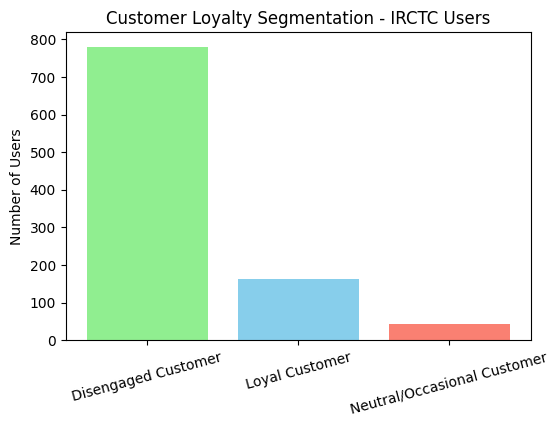

In [0]:
# ------------------------------------------------------------
# 📈 Step 10: Visualize Loyalty Distribution
# ------------------------------------------------------------
loyalty_counts = predictions.groupBy("loyalty_segment").count().toPandas()
plt.figure(figsize=(6,4))
plt.bar(loyalty_counts["loyalty_segment"], loyalty_counts["count"], color=["lightgreen","skyblue","salmon"])
plt.title("Customer Loyalty Segmentation - IRCTC Users")
plt.ylabel("Number of Users")
plt.xticks(rotation=15)
plt.show()

In [0]:
# ------------------------------------------------------------
# 🧾 Step 11: Summary Insights
# ------------------------------------------------------------
total_users = predictions.count()
loyal = predictions.filter(col("loyalty_segment") == "Loyal Customer").count()
neutral = predictions.filter(col("loyalty_segment") == "Neutral/Occasional Customer").count()
disengaged = predictions.filter(col("loyalty_segment") == "Disengaged Customer").count()

print("\n🔍 Insights Summary:")
print(f"Total Users Analyzed: {total_users}")
print(f"Loyal Customers: {loyal} ({loyal/total_users*100:.2f}%)")
print(f"Neutral Customers: {neutral} ({neutral/total_users*100:.2f}%)")
print(f"Disengaged Customers: {disengaged} ({disengaged/total_users*100:.2f}%)")

print("\n✅ Use Case 5 executed successfully — Customer Loyalty & Engagement Insights completed!")



🔍 Insights Summary:
Total Users Analyzed: 986
Loyal Customers: 163 (16.53%)
Neutral Customers: 43 (4.36%)
Disengaged Customers: 780 (79.11%)

✅ Use Case 5 executed successfully — Customer Loyalty & Engagement Insights completed!


In [0]:
# ------------------------------------------------------------
# 💾 Step 12: Save Final Segmentation Results
# ------------------------------------------------------------
output_df = predictions.select("userName", "review_count", "avg_score", "positive_ratio", "loyalty_segment")
output_path = "/Workspace/exports/IRCTC_Loyalty_Segmentation_Results.csv"
output_df.toPandas().to_csv(output_path, index=False)
print(f"📁 Loyalty segmentation results saved at: {output_path}")

📁 Loyalty segmentation results saved at: /Workspace/exports/IRCTC_Loyalty_Segmentation_Results.csv
